**Exercise 3: Corner detection**

*CPSC 480/580: Computer Vision*

*Yale University*

*Instructor: Alex Wong*

Implements the Moravec corner detector and applies it onto several images, with and without noise. Experiment with Harris corner detector from scikit-image and compare it with Moravec detector.

Import packages

In [1]:
import skimage.data
import skimage.feature
import numpy as np
import matplotlib.pyplot as plt

Utility functions for plotting

In [2]:
def config_plot():
    '''
    Function to remove axis tickers and box around figure
    '''

    plt.box(False)
    plt.axis('off')

In [5]:
def extract_image_patch(image, patch_size, yx):
    '''
    Extract a patch of size k x k at (y, x) location of the image

    Arg(s):
        image : numpy[float32]
            H x W x C image
        patch_size : tuple[int]
            (k1, k2) k1 and k2 are the dimensions of the patch
        yx : numpy[float]
            [y, x] location of where to extract the patch
    Returns:
        numpy[float32] : k x k patch located at (y, x) coordinate of the image
    '''

    # TODO: Determine start and end to slice the array for each y-, x-direction
    y_start = yx[0] - patch_size[0] // 2
    y_end = yx[0] + patch_size[0] // 2
    x_start = yx[1] - patch_size[1] // 2
    x_end = yx[1] + patch_size[1] // 2

    # TODO: Returns a patch of size k x k at (y, x) location of the image
    return image[y_start:y_end, x_start:x_end]

In [6]:
def sum_squared_difference(src, tgt):
    '''
    Computes sum of squared difference (SSD) between two vectors

    Arg(s):
        src : numpy[float32]
            N element source vector
        tgt : numpy[float32]
            N element target vector
    Returns:
        float : sum of squared differences (SSD) between two vectors
    '''

    # TODO: Compute sum of squared differences
    return np.sum((src - tgt) ** 2)

Loading data

In [7]:
# Load checkerboard image from skimage
image_checkerboard = skimage.data.checkerboard()

# Load coins image from skimage
image_coin = skimage.data.coins()

images = [image_checkerboard, image_coin]
images_gray = [None] * len(images)
images_noisy = [None] * len(images)

# TODO: Create gray (if images aren't already) and noisy versions of them with variance of 0.005
for idx, image in enumerate(images):

    # TODO: Convert images to gray if it isn't already
    if len(image.shape) > 2 and image.shape[-1] > 1:
        image_gray = skimage.color.rgb2gray(image)
    else:
        image_gray = image

    images_gray[idx] = image_gray

    # TODO: Add noise to simulate noisy capture for images
    image_noisy = 255 * skimage.util.random_noise(image_gray, mode='gaussian', var=0.005)

    images_noisy[idx] = image_noisy

# TODO: Unpack images to checkerboard and coin
image_checkerboard_gray, image_coin_gray = images_gray
image_checkerboard_noisy, image_coin_noisy = images_noisy

Moravec corner detector

In [8]:
def moravec_corner(image_gray, patch_size, threshold):
    '''
    Detects corners using Moravec corner detector

    Arg(s):
        image_gray : numpy[float32]
            H x W gray/monochrome image
        patch_size : numpy[float32]
            (h, w) tuple denoting the height and width of the patch
        threshold : float
            threshold for determining if response is a corner
    Returns:
        numpy[float32] : H x W Moravec response image
        numpy[float32] : N x 2 array of corner coordinates
    '''

    # TODO: Pad image based on patch size
    padding_y = patch_size[0] // 2 + 1
    padding_x = patch_size[1] // 2 + 1

    image_gray_padded = np.pad(
        image_gray,
        [(padding_y, padding_y), (padding_x, padding_x)],
        mode='edge')

    # TODO: Allocate image to hold minimum SSD values
    image_moravec = np.zeros(image_gray.shape[0:2])

    # TODO: Compute minimum dissimilarity for patches centered at each pixel
    n_height, n_width = image_gray_padded.shape

    for y in range(padding_y, n_height - 2 * padding_y):
        for x in range(padding_x, n_width - 2 * padding_x):

            # Extract patch at yx
            image_gray_yx = extract_image_patch(
                image=image_gray_padded,
                patch_size=patch_size,
                yx=[y, x])

            # Extract patch at y + 1, x
            image_gray_shift_down = extract_image_patch(
                image=image_gray_padded,
                patch_size=patch_size,
                yx=[y + 1, x])

            # Extract patch at y, x + 1
            image_gray_shift_right = extract_image_patch(
                image=image_gray_padded,
                patch_size=patch_size,
                yx=[y, x + 1])

            # Extract patch at y + 1, x - 1
            image_gray_shift_left_down = extract_image_patch(
                image=image_gray_padded,
                patch_size=patch_size,
                yx=[y + 1, x - 1])

            # Extract patch at y + 1, x - 1
            image_gray_shift_right_down = extract_image_patch(
                image=image_gray_padded,
                patch_size=patch_size,
                yx=[y + 1, x + 1])

            # SSD scores for the local patch
            ssd_scores = [
                sum_squared_difference(image_gray_yx, image_gray_shift_down),
                sum_squared_difference(image_gray_yx, image_gray_shift_right),
                sum_squared_difference(image_gray_yx, image_gray_shift_left_down),
                sum_squared_difference(image_gray_yx, image_gray_shift_right_down)
            ]

            # Choose minimum SSD score
            image_moravec[y, x] = min(ssd_scores)

    # TODO: Shift Moravec response map to the top to align responses to image
    image_moravec = np.pad(
        image_moravec,
        [(0, padding_y), (0, padding_x)],
        mode='constant')

    image_moravec = image_moravec[padding_y:, padding_x:]

    # TODO: Convert Moravec response map to corner map by threshold
    corner_moravec = np.where(image_moravec < threshold, 0, 1)

    # TODO: Convert Moravec corner map to coordinates
    yx_moravec = np.where(corner_moravec > 0)

    return image_moravec, np.stack(yx_moravec, axis=-1)

Moravec corner detector

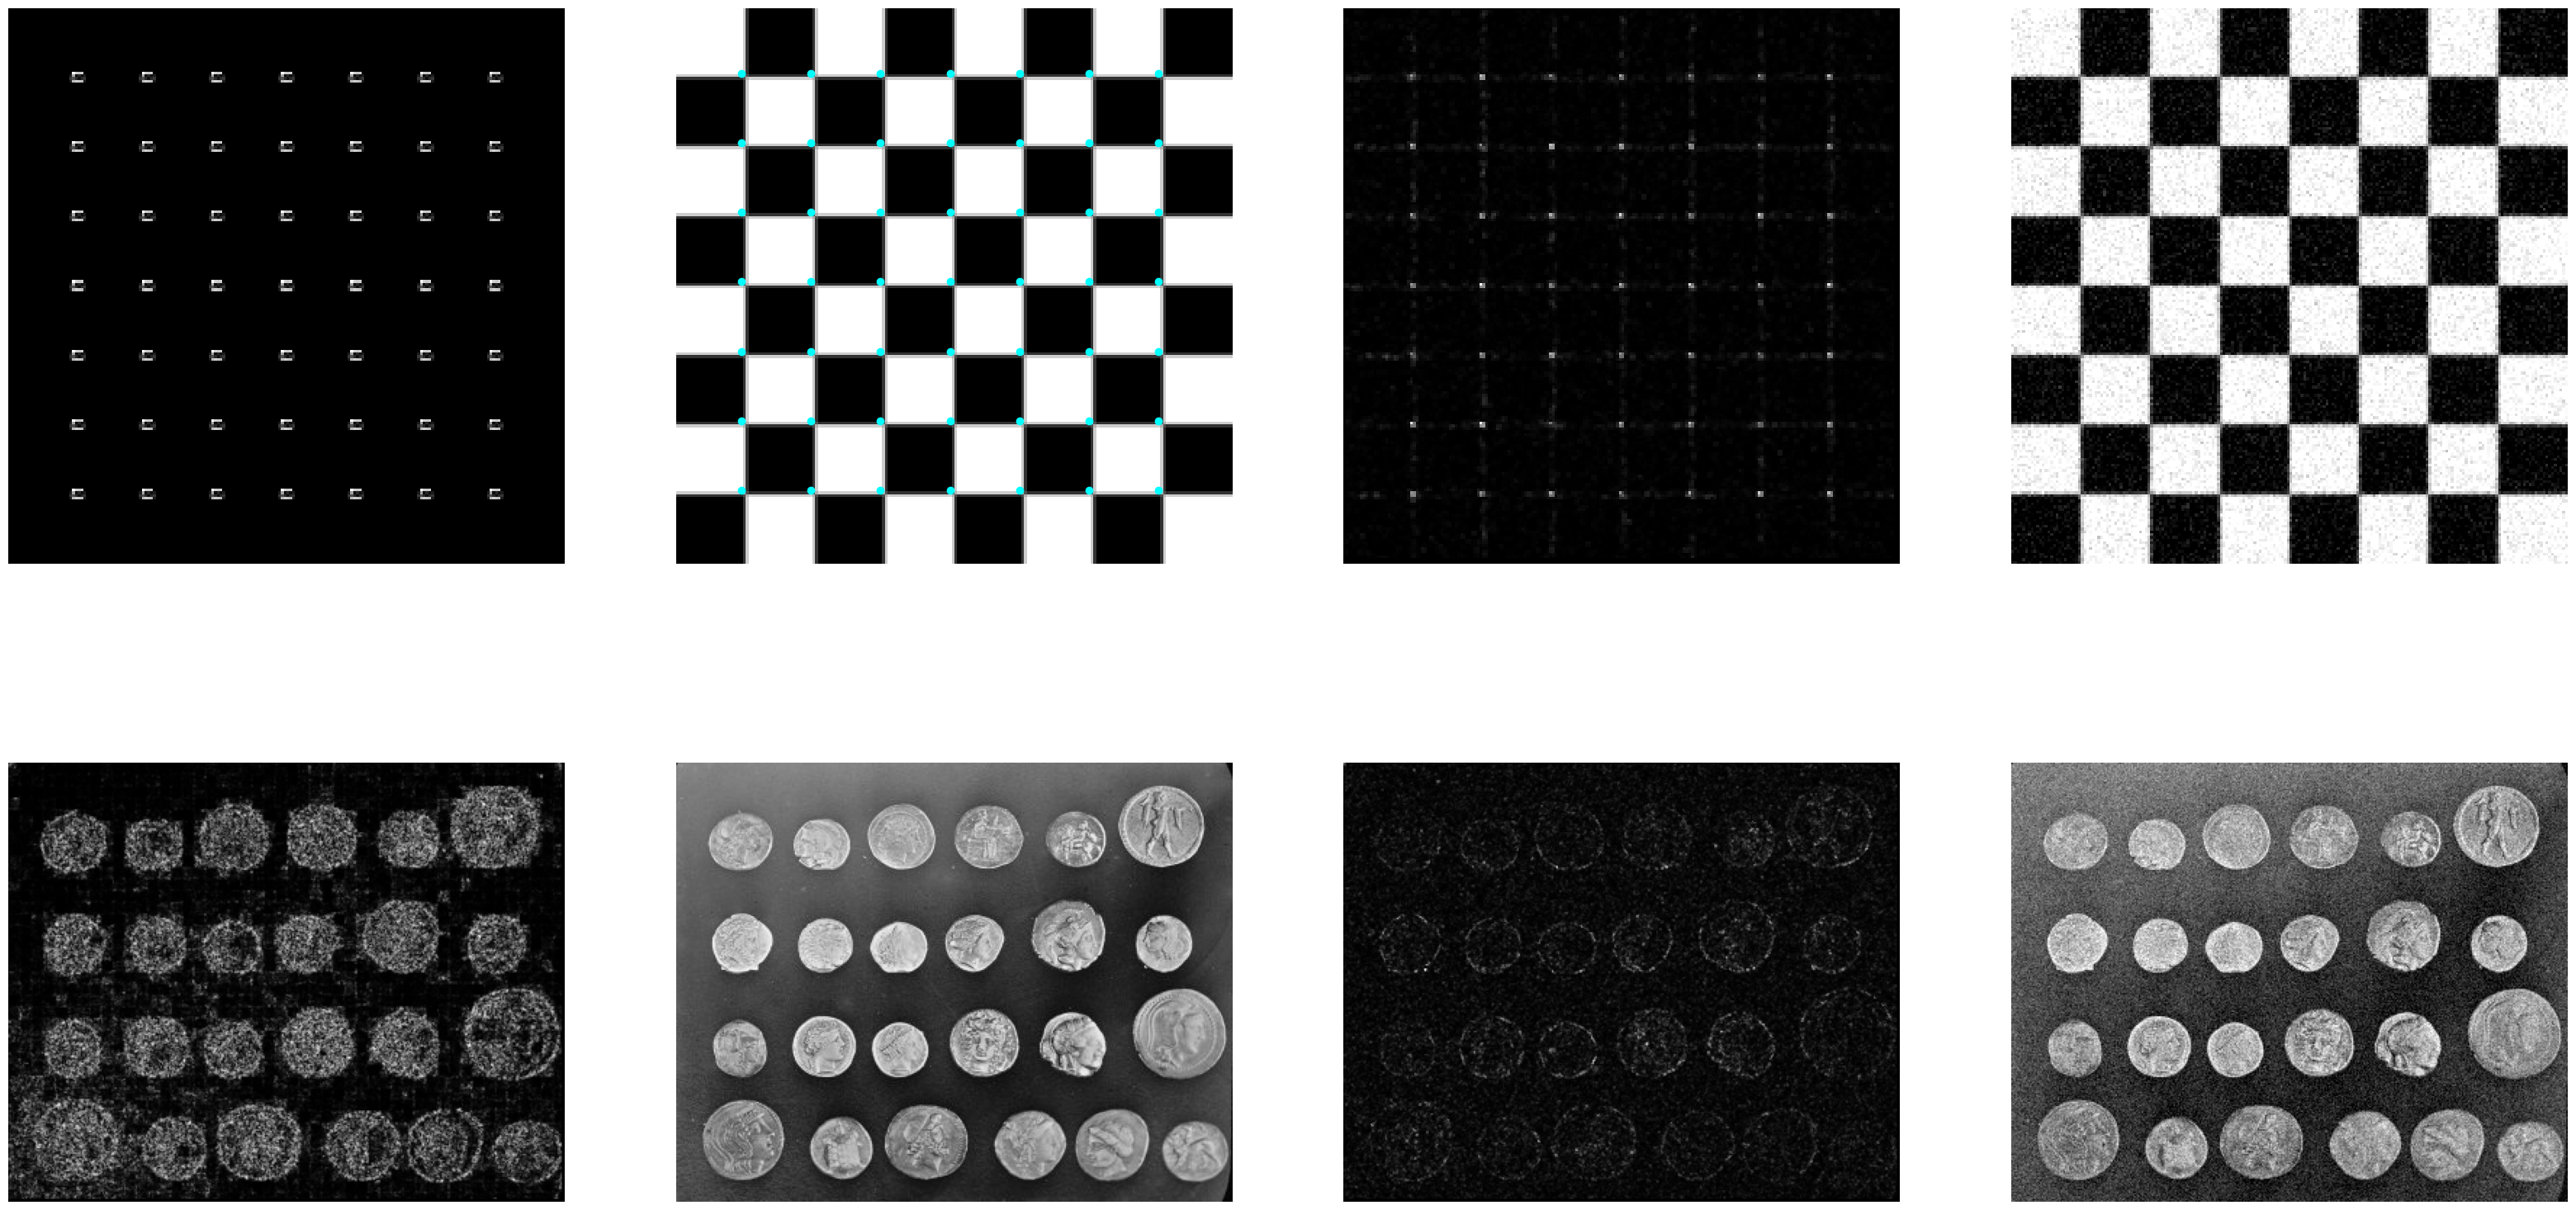

In [9]:
patch_size_moravec = [3, 3]

# TODO: Run moravec corner detector on coin image with threshold of 510
image_coin_gray_moravec, yx_coin_gray_moravec = moravec_corner(
    image_coin_gray,
    patch_size=patch_size_moravec,
    threshold=510)

# TODO: Run moravec corner detector on noisy coin image with threshold of 8000
image_coin_noisy_moravec, yx_coin_noisy_moravec = moravec_corner(
    image_coin_noisy,
    patch_size=patch_size_moravec,
    threshold=8000)

# TODO: Run moravec corner detector on checkerboard image with threshold of 300
image_checkerboard_gray_moravec, yx_checkerboard_gray_moravec = moravec_corner(
    image_checkerboard_gray,
    patch_size=patch_size_moravec,
    threshold=300)

# TODO: Run moravec corner detector on noisy checkerboard image with threshold of 8000
image_checkerboard_noisy_moravec, yx_checkerboard_noisy_moravec = moravec_corner(
    image_checkerboard_noisy,
    patch_size=patch_size_moravec,
    threshold=8000)

# Create visualization
fig = plt.figure(figsize=(40, 42))

ax = fig.add_subplot(4, 4, 1)
ax.imshow(image_checkerboard_gray_moravec, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 2)
ax.imshow(image_checkerboard_gray, cmap='gray')

# TODO: Plot points from Moravec corner for checkerboard
ax.plot(yx_checkerboard_gray_moravec[:, 1], yx_checkerboard_gray_moravec[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
config_plot()

ax = fig.add_subplot(4, 4, 3)
ax.imshow(image_checkerboard_noisy_moravec, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 4)
ax.imshow(image_checkerboard_noisy, cmap='gray')

# TODO: Plot points from Moravec corner for noisy checkerboard

config_plot()

ax = fig.add_subplot(4, 4, 5)
ax.imshow(image_coin_gray_moravec, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 6)
ax.imshow(image_coin_gray, cmap='gray')

# TODO: Plot points from Moravec corner for coin

config_plot()

ax = fig.add_subplot(4, 4, 7)
ax.imshow(image_coin_noisy_moravec, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 8)
ax.imshow(image_coin_noisy, cmap='gray')

# TODO: Plot points from Moravec corner for noisy coin

config_plot()

plt.show()

Harris corner detector

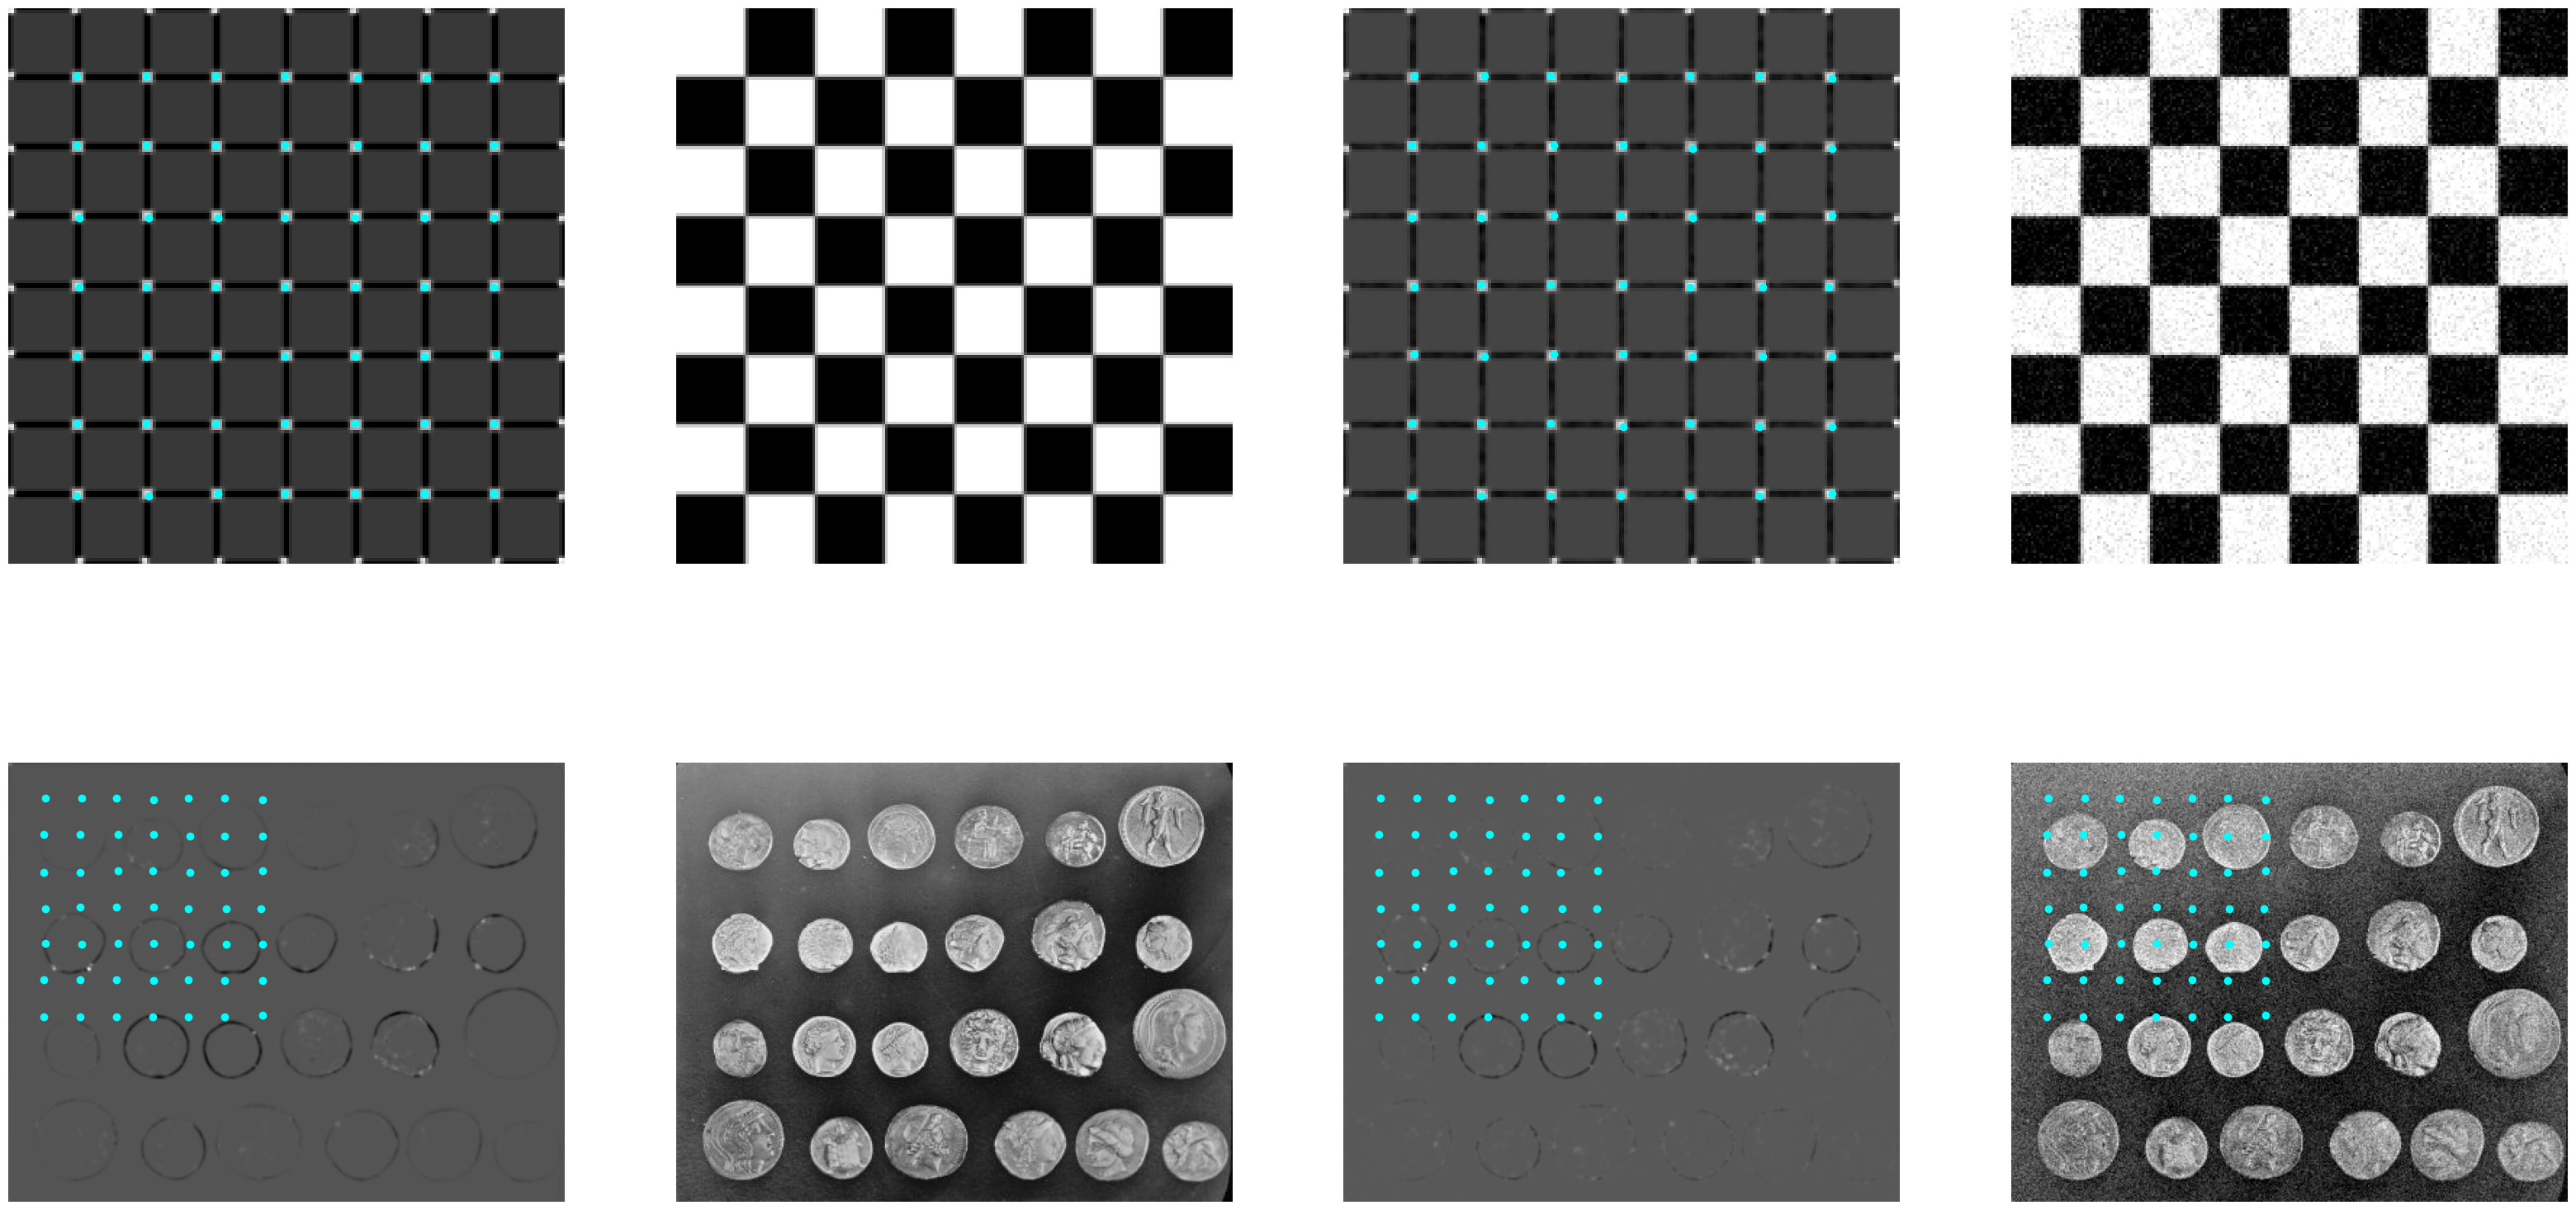

In [14]:
from skimage.feature import corner_harris, corner_peaks

# TODO: Run Harris detector on gray and noisy checkerboard images using skimage
image_checkerboard_gray_harris = corner_harris(image_checkerboard_gray)
image_checkerboard_noisy_harris = corner_harris(image_checkerboard_noisy)

# TODO: Run Harris detector on gray and noisy coin images using skimage
image_coin_gray_harris = corner_harris(image_coin_gray)
image_coin_noisy_harris = corner_harris(image_coin_noisy)

min_distance = 5
threshold_rel = 0.02

# TODO: Get corner peaks from Harris response maps for gray and noisy checkerboard images using skimage with min_distance of 5 and threshold_rel of 0.02
yx_checkerboard_gray_harris = corner_peaks(image_checkerboard_gray_harris, min_distance=min_distance, threshold_rel=threshold_rel)
yx_checkerboard_noisy_harris = corner_peaks(image_checkerboard_noisy_harris, min_distance=min_distance, threshold_rel=threshold_rel)

# TODO: Get corner peaks from Harris response maps for gray and noisy coin images using skimage with min_distance of 5 and threshold_rel of 0.02
yx_coin_gray_harris = corner_peaks(image_coin_gray_harris, min_distance=min_distance, threshold_rel=threshold_rel)
yx_coin_noisy_harris = corner_peaks(image_coin_noisy_harris, min_distance=min_distance, threshold_rel=threshold_rel)

# Create visualization
fig = plt.figure(figsize=(40, 42))

ax = fig.add_subplot(4, 4, 1)
ax.imshow(image_checkerboard_gray_harris, cmap='gray')
config_plot()
ax.plot(yx_checkerboard_gray_harris[:, 1], yx_checkerboard_gray_harris[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)

ax = fig.add_subplot(4, 4, 2)
ax.imshow(image_checkerboard_gray, cmap='gray')

# TODO: Plot points from Harris corner for checkerboard

config_plot()

ax = fig.add_subplot(4, 4, 3)
ax.imshow(image_checkerboard_noisy_harris, cmap='gray')
config_plot()
ax.plot(yx_checkerboard_noisy_harris[:, 1], yx_checkerboard_noisy_harris[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)

ax = fig.add_subplot(4, 4, 4)
ax.imshow(image_checkerboard_noisy, cmap='gray')

# TODO: Plot points from Harris corner for noisy checkerboard

config_plot()

ax = fig.add_subplot(4, 4, 5)
ax.imshow(image_coin_gray_harris, cmap='gray')
config_plot()
ax.plot(yx_checkerboard_noisy_harris[:, 1], yx_checkerboard_noisy_harris[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)


ax = fig.add_subplot(4, 4, 6)
ax.imshow(image_coin_gray, cmap='gray')

# TODO: Plot points from Harris corner for coin

config_plot()

ax = fig.add_subplot(4, 4, 7)
ax.imshow(image_coin_noisy_harris, cmap='gray')
config_plot()
ax.plot(yx_checkerboard_noisy_harris[:, 1], yx_checkerboard_noisy_harris[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)

ax = fig.add_subplot(4, 4, 8)
ax.imshow(image_coin_noisy, cmap='gray')


# TODO: Plot points from Harris corner for noisy coin

config_plot()

plt.show()